# 과제

1. 파이썬을 사용하여 무비렌즈 데이터(ml_latest-small)를 전처리 및 EDA
- 유의미한 분석 5개 이상

2. Memory based CF 2개 이상, Model based CF 2개 이상 알고리즘을 사용하여 
- 성능 평가
- 추천 결과 출력

 Surprise library 사용 가능



# 1. 데이터 수집 및 전처리, EDA

In [16]:
pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [223 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-cpython-310
      creating build/lib.macosx-10.9-x86_64-cpython-310/surprise
      copying surprise/builtin_datasets.py -> build/lib.macosx-10.9-x86_64-cpython-310/surprise
      copying surprise/__init__.py -> build/lib.macosx-10.9-x86_64-cpython-310/surprise
      copying surprise/dump.py -> build/lib.macosx-10.9-x86_64-cpython-310/surprise
      copying surprise/dataset.py -> build/lib.macosx-10.9-x86_64-cpython-310/surprise
      copying surprise/reader.py -> build/lib.macosx-10.9-x86_64-cpython-310/surprise
      copying surprise/utils.py -> build/lib.macosx-10.9-x86_64-cpython-3

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [49]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import SVD
from surprise import SVDpp
from surprise.accuracy import rmse, mae
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [3]:
from tensorflow.keras.utils import get_file
import os

zip_fname = 'ml-latest-small.zip'
data_dir = 'ml-latest-small'
ratings_fname = 'ratings.csv'
movies_fname = 'movies.csv'
origin = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
path = get_file(zip_fname, origin, extract=True)

path = path.replace(zip_fname, data_dir)
ratings_path = os.path.join(path, ratings_fname)
movies_path = os.path.join(path, movies_fname)

2023-03-21 19:09:35.739960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


978202/978202 [==============================] - 2s 2us/step


## ratings_df

In [4]:
import pandas as pd
import numpy as np

ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [11]:
ratings_df.shape

(100836, 4)

In [13]:
print('userId data의 결측치 개수: ', ratings_df['userId'].isnull().sum())
print('movieId data의 결측치 개수: ', ratings_df['movieId'].isnull().sum())
print('rating data의 결측치 개수: ', ratings_df['rating'].isnull().sum())


userId data의 결측치 개수:  0
movieId data의 결측치 개수:  0
rating data의 결측치 개수:  0


userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [10]:
print('{} Ratings, {} Users, {} Movies'.format(len(ratings_df), 
                                               len(ratings_df.userId.unique()), 
                                               len(ratings_df.movieId.unique())))

100836 Ratings, 610 Users, 9724 Movies


In [34]:
pvdata = pd.pivot(index = 'movieId',columns = 'userId', data = ratings_df,values ='rating')
pvdata.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
pvdata.shape

(9724, 610)

In [36]:
pvdata.fillna(0,inplace = True)
pvdata.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
pvdata_final = pvdata.loc[numberOf_user_voted_for_movie[numberOf_user_voted_for_movie['rating'] > 10]['movieId'],:]
pvdata_final = pvdata.loc[:,numberOf_movies_voted_by_user[numberOf_movies_voted_by_user['rating'] > 60]['userId']]
pvdata_final.shape

(9724, 334)

In [47]:
pvdata_final # 0이 많이 포함된 SPARse한 matrix

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Sparsity 줄이기

from scipy.sparse import csr_matrix
csr_data = csr_matrix(pvdata_final.values)
pvdata_final.reset_index(inplace=True)
pvdata_final.head()


userId,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# EDA : movie id 별 voting 수
numberOf_user_voted_for_movie = pd.DataFrame(ratings_df.groupby('movieId')['rating'].agg('count'))
numberOf_user_voted_for_movie.reset_index(level = 0,inplace = True)
numberOf_user_voted_for_movie.head()

,movieId,rating
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


In [38]:
numberOf_user_voted_for_movie.describe()

,movieId,rating
count,9724.000000,9724.000000
mean,42245.024373,10.369807
std,52191.137320,22.401005
min,1.000000,1.000000
25%,3245.500000,1.000000
50%,7300.000000,3.000000
75%,76739.250000,9.000000
max,193609.000000,329.000000


In [39]:
# userId별 voting 수
numberOf_movies_voted_by_user = pd.DataFrame(ratings_df.groupby('userId')['rating'].agg('count'))     
numberOf_movies_voted_by_user.reset_index(level = 0,inplace = True)
numberOf_movies_voted_by_user.head()

,userId,rating
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [40]:
numberOf_movies_voted_by_user.describe()

,userId,rating
count,610.000000,610.000000
mean,305.500000,165.304918
std,176.236111,269.480584
min,1.000000,20.000000
25%,153.250000,35.000000
50%,305.500000,70.500000
75%,457.750000,168.000000
max,610.000000,2698.000000


Text(0, 0.5, 'Number Of Users Voted for Movie')

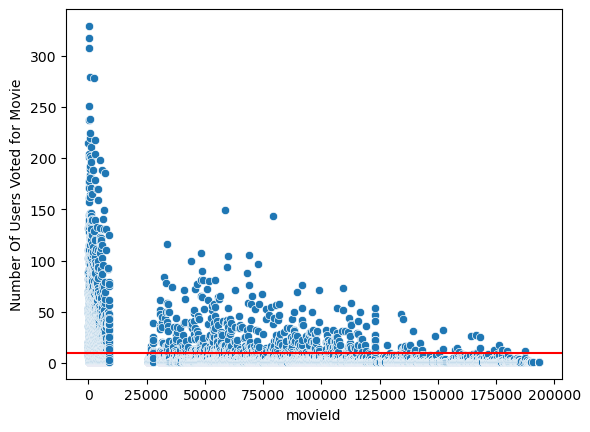

In [43]:
plt.figure()
ax = sns.scatterplot(y = 'rating', x = 'movieId', data = numberOf_user_voted_for_movie)
plt.axhline(y=10,color='r')
plt.ylabel('Number Of Users Voted for Movie')
# MovieID가 낮은 영화의 투표값이 많다.
# MoVieID 중 rating이 없는 id 구간이 있다. (25000이전)
# 25000 이후의 MovieID에서는 비슷한 rating수가 존재하지만, movidID가 커질수록 voting 수가 점차 적어지는 경향이 있다. 


Text(0, 0.5, 'Number Of Movies rated by user')

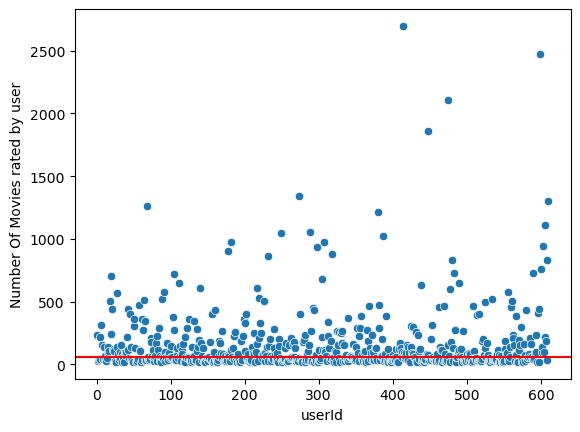

In [44]:
plt.figure()
ax = sns.scatterplot(y = 'rating', x = 'userId', data = numberOf_movies_voted_by_user)
plt.axhline(y=60,color='r')
plt.ylabel('Number Of Movies rated by user')
# userID와 rating수는 거의 상관관계가 없다. 
# userID가 뒷 번호인 사람 중 몇 명의 Outlier가 굉장히 많은 rating을 진행하였다.

## movies_df

In [5]:
movies_df = pd.read_csv(movies_path)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
movies_df.shape

(9742, 3)

In [8]:
print('title의 결측치 개수: ', movies_df['title'].isnull().sum())
print('movieId data의 결측치 개수: ', movies_df['movieId'].isnull().sum())
print('genres의 결측치 개수: ', movies_df['genres'].isnull().sum())


title의 결측치 개수:  0
movieId data의 결측치 개수:  0
genres의 결측치 개수:  0


## Surprise

In [18]:
# surprise를 사용하기 위해 reader object를 만든다
reader = Reader(rating_scale=(0.5, 5.0))

In [51]:
# Load data into a Dataset object for surprise
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [20]:
# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

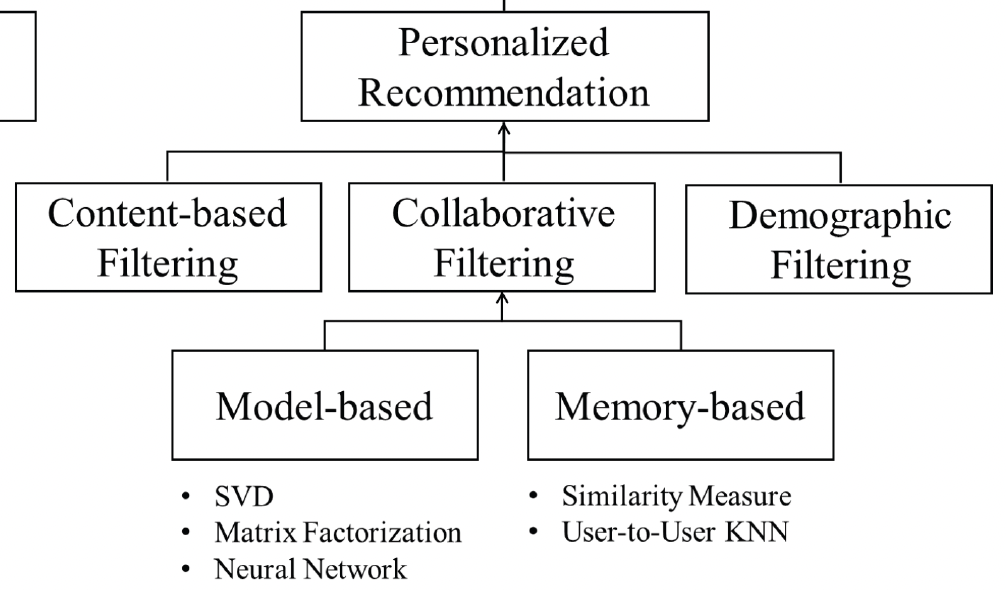

## 2. Model Based CF (latent factor model)
1. Item, User 값을 인덱스 값으로 변환한다.
2. 잠재 인수(Latent factor)의 개수를 정한다.
3. 잠재 인수(Latent factor)를 임베딩(Embedding) 한다.
4. 벡터화(Flatten) 해서 잠재 벡터(Latent vector)로 변환한다.
5. R^ 를 Item과 User의 잠재 벡터의 내적(dot) 으로 설정한다.
6. 손실 함수 (Loss function)를 정의한다. 여기서는 평균 제곱 오차(mean squared error) 를 사용한다.
7. 옵티마이저(Optimizer)를 정의한다. 여기서는 Adam 을 사용한다.
8. 반복할 회수(epoch)를 결정한다.
9. 주어진 조건으로 모델을 최적화(fit) 시킨다.

## SVD Model

In [21]:
# Build a collaborative filtering model using SVD
model = SVD()

In [22]:
# Train the model on the training set
model.fit(trainset)

In [23]:
# Make predictions on the test set
predictions = model.test(testset)

In [24]:
# Evaluate the performance of the model
rmse_score = rmse(predictions)
mae_score = mae(predictions)
print(f'RMSE: {rmse_score:.2f}')
print(f'MAE: {mae_score:.2f}')

RMSE: 0.8713
MAE:  0.6711
RMSE: 0.87
MAE: 0.67


In [25]:
# Generate recommendations for a target user
target_user = 1
target_movies = ratings_df[ratings_df['userId'] == target_user]['movieId']
target_movies = target_movies[~target_movies.isin(predictions)]
target_movies = list(set(target_movies))

In [27]:
target_ratings = [{'userId': target_user, 'movieId': movie_id, 'rating': model.predict(target_user, movie_id).est} for movie_id in target_movies]

target_recommendations = pd.DataFrame(target_ratings).sort_values('rating', ascending=False).merge(movies_df, on='movieId')
target_recommendations.head()

,userId,movieId,rating,title,genres
0,1,1136,5.0,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
1,1,457,5.0,"Fugitive, The (1993)",Thriller
2,1,1089,5.0,Reservoir Dogs (1992),Crime|Mystery|Thriller
3,1,923,5.0,Citizen Kane (1941),Drama|Mystery
4,1,527,5.0,Schindler's List (1993),Drama|War


## SVDpp

In [57]:
model = SVDpp()
model.fit(trainset)
predictions = model.test(testset)

In [ ]:
rmse_score = rmse(predictions)
mae_score = mae(predictions)
print(f'RMSE: {rmse_score:.2f}')
print(f'MAE: {mae_score:.2f}')

In [58]:
target_user = 1
target_movies = ratings_df[ratings_df['userId'] == target_user]['movieId']
target_movies = target_movies[~target_movies.isin(predictions)]
target_movies = list(set(target_movies))

In [59]:
target_ratings = [{'userId': target_user, 'movieId': movie_id, 'rating': model.predict(target_user, movie_id).est} for movie_id in target_movies]

target_recommendations = pd.DataFrame(target_ratings).sort_values('rating', ascending=False).merge(movies_df, on='movieId')
target_recommendations.head()

,userId,movieId,rating,title,genres
0,1,3147,5.0,"Green Mile, The (1999)",Crime|Drama
1,1,954,5.0,Mr. Smith Goes to Washington (1939),Drama
2,1,527,5.0,Schindler's List (1993),Drama|War
3,1,923,5.0,Citizen Kane (1941),Drama|Mystery
4,1,1136,5.0,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy


## 3. Memory Based CF

## KNNwithMeans Model

In [60]:
model = KNNWithMeans()
model.fit(trainset)
predictions = model.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [61]:
rmse_score = rmse(predictions)
mae_score = mae(predictions)
print(f'RMSE: {rmse_score:.2f}')
print(f'MAE: {mae_score:.2f}')

RMSE: 0.8954
MAE:  0.6877
RMSE: 0.90
MAE: 0.69


In [62]:
target_user = 1
target_movies = ratings_df[ratings_df['userId'] == target_user]['movieId']
target_movies = target_movies[~target_movies.isin(predictions)]
target_movies = list(set(target_movies))

In [63]:
target_ratings = [{'userId': target_user, 'movieId': movie_id, 'rating': model.predict(target_user, movie_id).est} for movie_id in target_movies]

target_recommendations = pd.DataFrame(target_ratings).sort_values('rating', ascending=False).merge(movies_df, on='movieId')
target_recommendations.head()

,userId,movieId,rating,title,genres
0,1,553,5.000000,Tombstone (1993),Action|Drama|Western
1,1,1208,5.000000,Apocalypse Now (1979),Action|Drama|War
2,1,2571,4.975355,"Matrix, The (1999)",Action|Sci-Fi|Thriller
3,1,2580,4.952418,Go (1999),Comedy|Crime
4,1,954,4.952274,Mr. Smith Goes to Washington (1939),Drama


## KNNWithZScore model

In [64]:
model = KNNWithZScore()
model.fit(trainset)
predictions = model.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [65]:
rmse_score = rmse(predictions)
mae_score = mae(predictions)
print(f'RMSE: {rmse_score:.2f}')
print(f'MAE: {mae_score:.2f}')

RMSE: 0.8935
MAE:  0.6816
RMSE: 0.89
MAE: 0.68


In [66]:
target_user = 1
target_movies = ratings_df[ratings_df['userId'] == target_user]['movieId']
target_movies = target_movies[~target_movies.isin(predictions)]
target_movies = list(set(target_movies))

In [67]:
target_ratings = [{'userId': target_user, 'movieId': movie_id, 'rating': model.predict(target_user, movie_id).est} for movie_id in target_movies]

target_recommendations = pd.DataFrame(target_ratings).sort_values('rating', ascending=False).merge(movies_df, on='movieId')
target_recommendations.head()

,userId,movieId,rating,title,genres
0,1,1208,5.000000,Apocalypse Now (1979),Action|Drama|War
1,1,2571,4.982806,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2,1,608,4.953636,Fargo (1996),Comedy|Crime|Drama|Thriller
3,1,553,4.928690,Tombstone (1993),Action|Drama|Western
4,1,1136,4.902991,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy


## Summary 

In [52]:
benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), SVDpp(), KNNWithMeans(), KNNWithZScore()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fbe7c7b85e0>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7fbe7c8037c0>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7fbe7c8022f0>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7fbe7c803be0>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fbe7c7b85e0>


/var/folders/29/nzc3vbbx2xgfy9nbyx8n7tv80000gn/T/ipykernel_10086/2282333779.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fbe7c7b85e0> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7fbe7c8037c0>


/var/folders/29/nzc3vbbx2xgfy9nbyx8n7tv80000gn/T/ipykernel_10086/2282333779.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


Done:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7fbe7c8037c0> 


Starting:  <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7fbe7c8022f0>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/29/nzc3vbbx2xgfy9nbyx8n7tv80000gn/T/ipykernel_10086/2282333779.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


Done:  <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7fbe7c8022f0> 


Starting:  <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7fbe7c803be0>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Done:  <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7fbe7c803be0> 



	DONE



/var/folders/29/nzc3vbbx2xgfy9nbyx8n7tv80000gn/T/ipykernel_10086/2282333779.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


In [53]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.867079,29.951925,10.471085
SVD,0.881425,0.631116,0.245535
KNNWithMeans,0.904529,0.070485,2.027894
KNNWithZScore,0.905390,0.119867,2.212417
